In [2]:
!pip install nvcc4jupyter
%load_ext nvcc4jupyter

Source files will be saved in "/tmp/tmp8rxyfbog".


In [40]:
%%cuda

// Include necessary standard libraries
#include <stdio.h>
#include <cmath>
#include <iostream>
#include <algorithm>
#include <chrono>

using namespace std;
using namespace std::chrono;

// Constants defining the maximum capacity of the RRT
const int MAX_CHILDREN = 6; // Maximum children per node
const int MAX_NODES = 1000; // Maximum nodes before search fails

// For a node in the RRT
struct Node {
    float2 point; // Position in 2D space
    int parent; // Index of parent node
    int children[MAX_CHILDREN]; // Array of indices of children nodes
    int num_children; // Running count of number of children

    // Constructor initializing ndoe at specified point
    Node(float2 pt) : point(pt), parent(-1), num_children(0) {
        std::fill(children, children + MAX_CHILDREN, -1);
    }
    
    // Default constructor
    Node() : Node({0.0f, 0.0f}) {}
    
    // Print node details
    void to_string() {
        cout << "Point: (" << point.x << ", " << point.y << "), "
             << "Parent: " << parent << ", "
             << "Num children: " << num_children << ", Child: ";
        for (int i = 0; i < num_children; i++) {
            cout << children[i] << ", ";
        }
    }
    
    // Print node point
    void to_point() {
        cout << "(" << point.x << ", " << point.y << ")";
    }
};

// Calculate Euclidean distance between two points
double calculateDistance(const float2 p1, const float2 p2) {
    return sqrt((p1.x - p2.x) * (p1.x - p2.x) + (p1.y - p2.y) * (p1.y - p2.y));
}

// Find the nearest node index to random point in the tree
int qnear_idx(float2* h_points, float2 qrand, int n) {
    double min_distance = 10000;
    int min_idx = -1;
    for (int i = 0; i < n; i++) {
        double distance = calculateDistance(h_points[i], qrand);
        if (distance < min_distance) {
            min_distance = distance;
            min_idx = i;
        }
    }
    
    return min_idx;
}

// Check if point is within an arbitrary obstacle space
bool is_collision(const float2& q) {    
    if (calculateDistance(q, {20, 30}) < 15) {
        return true;
    }
    
    if (calculateDistance(q, {50, 30}) < 10) {
        return true;
    }
    
    if (calculateDistance(q, {50, 70}) < 10) {
        return true;
    }
    
    if (calculateDistance(q, {80, 70}) < 15) {
        return true;
    }
    
    if (0 >= q.x || 0 >= q.y || q.x >= 100 || q.y >= 100) {
        return true;
    }
    
    return false;
}

// Valididate if the direct path between two points is in free space
bool valid_edge(const float2 q0, const float2 q1, int num_steps = 5) {
    float2 step;
    step.x = (q1.x - q0.x) / num_steps; // X direction increment
    step.y = (q1.y - q0.y) / num_steps; // Y direction increment
    
    // Check all intermediate points
    float2 q = q0;
    for (int i = 0; i < num_steps; i++) {
        if (is_collision(q)) {
            return false;
        }
        q.x += step.x;
        q.y += step.y;
    }
    return !is_collision(q1);
}

// Compute the new point moving step size from qnear towards qrand
float2 compute_qnew(const float2 qnear, const float2 qrand, float step_size) {
    float2 qnew = qnear;
    float2 step;
    step.x = qrand.x - qnear.x;
    step.y = qrand.y - qnear.y;
    float L2 = calculateDistance(qnear, qrand);
    if (L2 > step_size) {
        float multiple = step_size / L2;
        qnew.x += multiple * step.x;
        qnew.y += multiple * step.y;
    } else {
        qnew = qrand;
    }
    return qnew;
}

// Implementation of the RRT algorithm
void rrt(const float2 start, const float2 goal, float bias, Node nodes[MAX_NODES], float2 V[MAX_NODES], int X, float step_size, bool verbose=false) {
    int V_size = 1; // Number of points sampled
    V[0] = start; // Array of all points
    nodes[0] = Node(start); // Array of all nodes
    bool goal_found = false;
    
    // Continue expanding the tree until maximum nodes are reached
    while (V_size < MAX_NODES) {
        // E-greedy determination of next direction to attempt to expand in
        float2 qrand;
        float p = static_cast <float> (rand()) / static_cast <float> (RAND_MAX);
        if (p > bias) {
            // Exploration - random direction
            qrand.x = static_cast <float> (rand()) / (static_cast <float> (RAND_MAX/X));
            qrand.y = static_cast <float> (rand()) / (static_cast <float> (RAND_MAX/X));
        } else {
            // Exploitation - direction of the goal
            qrand = goal;
        }
        
        // Find the nearest neighbor in the tree
        int qnear_index = qnear_idx(V, qrand, V_size);
        float2 qnear = V[qnear_index];
        // Compute a new feasible point in the direction of expansion
        float2 qnew = compute_qnew(V[qnear_index], qrand, step_size);
        
        // Add new node and connect new edge if the edge is valid
        if (valid_edge(qnear, qnew) and nodes[qnear_index].num_children < MAX_CHILDREN) {
            int qnew_index = V_size;
            nodes[qnew_index] = Node(qnew); // Create new node for point
            V[qnew_index] = qnew; // Store new point
            nodes[qnew_index].parent = qnear_index; // Set parent of new node
            nodes[qnear_index].children[nodes[qnear_index].num_children++] = qnew_index; // Add new node as child
            V_size++; // Increment the number of sampled points

            // Perform goal test
            for (int i = 0; i < V_size; i++) {
                if (V[i].x == goal.x && V[i].y == goal.y) {
                    goal_found = true;
                    break;
                }
            }
            if (goal_found) {
                break;
            }
        }
    }
    
    if (verbose) {
        cout << "PRINTING ENTIRE TREE _______________" << endl;
        cout << "NODES _______" << endl;
        for (int i = 0; i < V_size; i++) {
            cout << "Node " << i << " - ";
            nodes[i].to_string();
            cout << endl;
        }

        cout << "POINTS _______" << endl;
        for (int i = 0; i < V_size; i++) {
            cout << "Point " << i << " - [" << V[i].x << ", " << V[i].y << "]" << endl;
        }
        cout << "PRINTING FOUND PATH _______________" << endl;
        if (goal_found) {
            if (goal_found) {
                cout << "Found Path!!!" << endl;
                Node path[MAX_NODES];
                int path_length = 0;
                Node node = nodes[V_size - 1];
                while (node.parent != -1) {
                    path[path_length++] = node;
                    node = nodes[node.parent];
                }
                path[path_length++] = node;
                Node short_path[path_length];
                for (int i = 0; i < path_length; i++) {
                    short_path[i] = path[path_length - i - 1];
                }

                for (int i = 0; i < path_length; i++) {
                    cout << i << " - ";
                    short_path[i].to_point();
                    if (i != path_length - 1) {
                        cout << "->" << endl;
                    } else {
                        cout << endl;
                    }
                }
            }
        } else {
            cout << "Path to goal was not found..." << endl;
        }
    }
}

int main() {
    int X = 100; // Grid dimensions (square)
    float2 start = {1.0, 1.0}; // Start point
    float2 goal = {99.0, 99.0}; // Goal point
    float bias = 0.4; // Bias to exploit towards the goal
    float step_size = 2.0; // Maximum edge length
    Node nodes[MAX_NODES];
    float2 V[MAX_NODES];
    
    
    
    // Uncomment out to run RRT once in Verbose mode
    auto start_time = high_resolution_clock::now();
    
    rrt(start, goal, bias, nodes, V, X, step_size, true);
    
    // Note: execution times longer if distances are outputted
    auto end_time = high_resolution_clock::now();
    auto duration = duration_cast<microseconds>(end_time - start_time);
    cout << "Execution time: " << duration.count() << " microseconds" << endl;    
    
    
    
    // Uncomment out to get execution time of n trials
    /*
    microseconds totalDuration(0);
    
    int n_trials = 100;
    cout << "Expanding Rapidly Exploring Random Tree: " << n_trials << " times" << endl;

    for (int i = 0; i < n_trials; ++i) {
        auto start_time = high_resolution_clock::now();

        // Call the rrt function
        rrt(start, goal, bias, nodes, V, X, step_size);

        auto end_time = high_resolution_clock::now();
        auto duration = duration_cast<microseconds>(end_time - start_time);
        totalDuration += duration;
        
        cout << ".";
    }
    cout << endl;

    // Calculate average execution time
    auto averageDuration = totalDuration.count() / n_trials;
    cout << "Average execution time: " << averageDuration << " microseconds" << endl;
    */
    
    return 0;
}

PRINTING ENTIRE TREE _______________
NODES _______
Node 0 - Point: (1, 1), Parent: -1, Num children: 1, Child: 1, 
Node 1 - Point: (1.89041, 2.79086), Parent: 0, Num children: 1, Child: 2, 
Node 2 - Point: (3.85525, 3.16422), Parent: 1, Num children: 1, Child: 3, 
Node 3 - Point: (5.26434, 4.58355), Parent: 2, Num children: 1, Child: 4, 
Node 4 - Point: (6.07449, 6.41211), Parent: 3, Num children: 1, Child: 5, 
Node 5 - Point: (7.84221, 7.34762), Parent: 4, Num children: 2, Child: 6, 18, 
Node 6 - Point: (9.2818, 8.73599), Parent: 5, Num children: 2, Child: 7, 8, 
Node 7 - Point: (11.2743, 8.90906), Parent: 6, Num children: 1, Child: 9, 
Node 8 - Point: (8.39889, 10.5306), Parent: 6, Num children: 1, Child: 19, 
Node 9 - Point: (12.6696, 10.342), Parent: 7, Num children: 1, Child: 10, 
Node 10 - Point: (12.8701, 12.3319), Parent: 9, Num children: 3, Child: 11, 16, 69, 
Node 11 - Point: (14.2799, 13.7505), Parent: 10, Num children: 1, Child: 12, 
Node 12 - Point: (15.6897, 15.1691), Par

In [4]:
# Parse point data into array of points
def parse_points(point_data):
    tree = {}
    data = []
    lines = point_data.strip().split('\n')
    for line in lines:
        info = line.split('-')
        coords = info[1].strip()[1:-1]
        tree[tuple(map(float, coords.split(', ')))] = {}
        data.append(tuple(map(float, coords.split(', '))))
    return tree, data

# Parse node data into RRT tree
def parse_tree(node_data, tree, data):
    import re
    for line in node_data.strip().split('\n'):
        point = tuple(map(float, re.search(r'Point: \(([^)]+)\)', line).group(1).split(', ')))
        parent = int(re.search(r'Parent: (-?\d+)', line).group(1))
        if parent != -1:
            tree[point] = data[parent]
        else:
            tree[point] = None
    return tree

# Find path given RRT tree
def find_path(tree, data):
    path = []
    goal = data[-1]
    if tuple(goal) in tree:
        node = tuple(goal)
        while node:
            path.append(node)
            node = tree[node]
    return path

In [1]:
# Source: Tony Dear Computational Aspects of Robotics class

import numpy as np
from matplotlib import pyplot as plt

JOINT_LIMITS = np.array([100, 100])

def is_collision(q):
    calculateDistance = lambda p1, p2: ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5
    if (calculateDistance(q, (20, 30)) < 15):
        return True;
        
    if (calculateDistance(q, (50, 30)) < 10):
        return True;
    
    if (calculateDistance(q, (50, 70)) < 10):
        return True;
    
    if (calculateDistance(q, (80, 70)) < 15):
        return True;
    
    if (0 >= q[0] or 0 >= q[1] or q[0] >= 100 or q[1] >= 100):
        return true;

    return False

def visualize_cspace(start, goal, path, tree, num_samples=5000):
    obs_space = np.array([0,0])
    free_space = np.array([0,0])
    
    for i in range(num_samples):
        q = JOINT_LIMITS[0:2] * (np.random.random(2))
        if is_collision(q):
            obs_space = np.vstack((obs_space, q))
        else:
            free_space = np.vstack((free_space, q))

    plt.cla()
    plt.scatter(obs_space[1:,0], obs_space[1:,1], color='r')
    plt.scatter(free_space[1:,0], free_space[1:,1], color='lightskyblue')

    for node, parent in tree.items():
        if parent is not None:
            coords = [node[0], parent[0], node[1], parent[1]]
            if coords[0]*coords[1] > -6 and coords[2]*coords[3] > -6:            
                plt.plot(coords[:2], coords[2:], color='navy')   

    plt.scatter([start[0]], [start[1]], marker='x', s=300, color='green', label='start', zorder=2, linewidths=5)
    plt.scatter([goal[0]], [goal[1]], marker='+', s=500, color='yellow', label='goal', zorder=2, linewidths=5)

    if path:
        path = np.array(path)
        plt.scatter(path[:,0], path[:,1], marker='o', color='magenta', label='path', s=100)
        
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend(loc='upper left')
    plt.show()

In [2]:
def visualize_rrt(tree_string):
    # Extract node and point data
    node_data = tree_string.split('NODES _______')[1].split('POINTS _______')[0]
    point_data = tree_string.split('POINTS _______')[1].split('PRINTING FOUND PATH _______________')[0]
    
    # Extract tree and path from node and point data
    tree, data = parse_points(point_data)
    tree = parse_tree(node_data, tree, data)
    path = find_path(tree, data)

    # Graph path and tree
    visualize_cspace(data[0], data[-1], path, tree)

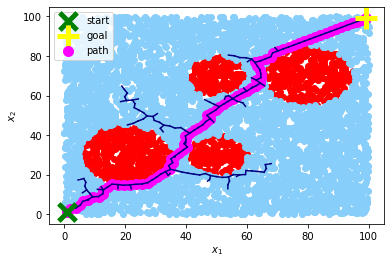

In [5]:
# Input the tree that was outputted by the RRT for visualization
visualize_rrt("""
PRINTING ENTIRE TREE _______________
NODES _______
Node 0 - Point: (1, 1), Parent: -1, Num children: 1, Child: 1, 
Node 1 - Point: (1.89041, 2.79086), Parent: 0, Num children: 1, Child: 2, 
Node 2 - Point: (3.85525, 3.16422), Parent: 1, Num children: 1, Child: 3, 
Node 3 - Point: (5.26434, 4.58355), Parent: 2, Num children: 1, Child: 4, 
Node 4 - Point: (6.07449, 6.41211), Parent: 3, Num children: 1, Child: 5, 
Node 5 - Point: (7.84221, 7.34762), Parent: 4, Num children: 2, Child: 6, 18, 
Node 6 - Point: (9.2818, 8.73599), Parent: 5, Num children: 2, Child: 7, 8, 
Node 7 - Point: (11.2743, 8.90906), Parent: 6, Num children: 1, Child: 9, 
Node 8 - Point: (8.39889, 10.5306), Parent: 6, Num children: 1, Child: 19, 
Node 9 - Point: (12.6696, 10.342), Parent: 7, Num children: 1, Child: 10, 
Node 10 - Point: (12.8701, 12.3319), Parent: 9, Num children: 3, Child: 11, 16, 69, 
Node 11 - Point: (14.2799, 13.7505), Parent: 10, Num children: 1, Child: 12, 
Node 12 - Point: (15.6897, 15.1691), Parent: 11, Num children: 1, Child: 13, 
Node 13 - Point: (17.6783, 14.9553), Parent: 12, Num children: 2, Child: 14, 138, 
Node 14 - Point: (19.646, 14.5975), Parent: 13, Num children: 1, Child: 15, 
Node 15 - Point: (21.6346, 14.8111), Parent: 14, Num children: 2, Child: 17, 126, 
Node 16 - Point: (10.8817, 12.5466), Parent: 10, Num children: 0, Child: 
Node 17 - Point: (23.6117, 15.1125), Parent: 15, Num children: 1, Child: 20, 
Node 18 - Point: (7.82321, 6.99064), Parent: 5, Num children: 0, Child: 
Node 19 - Point: (7.3568, 12.2376), Parent: 8, Num children: 2, Child: 38, 157, 
Node 20 - Point: (25.6051, 15.2755), Parent: 17, Num children: 1, Child: 21, 
Node 21 - Point: (27.4832, 15.963), Parent: 20, Num children: 1, Child: 22, 
Node 22 - Point: (28.9247, 17.3494), Parent: 21, Num children: 1, Child: 23, 
Node 23 - Point: (30.3559, 18.7464), Parent: 22, Num children: 1, Child: 24, 
Node 24 - Point: (31.6993, 20.228), Parent: 23, Num children: 1, Child: 25, 
Node 25 - Point: (33.2477, 21.4939), Parent: 24, Num children: 2, Child: 26, 44, 
Node 26 - Point: (34.8907, 22.6343), Parent: 25, Num children: 2, Child: 27, 35, 
Node 27 - Point: (34.3049, 24.5466), Parent: 26, Num children: 1, Child: 28, 
Node 28 - Point: (35.6167, 26.0562), Parent: 27, Num children: 1, Child: 29, 
Node 29 - Point: (35.062, 27.9778), Parent: 28, Num children: 1, Child: 30, 
Node 30 - Point: (36.4002, 29.4642), Parent: 29, Num children: 2, Child: 31, 73, 
Node 31 - Point: (37.7383, 30.9506), Parent: 30, Num children: 1, Child: 32, 
Node 32 - Point: (39.0764, 32.437), Parent: 31, Num children: 1, Child: 33, 
Node 33 - Point: (40.4146, 33.9234), Parent: 32, Num children: 1, Child: 34, 
Node 34 - Point: (39.4129, 35.6544), Parent: 33, Num children: 2, Child: 36, 95, 
Node 35 - Point: (36.8036, 22.0503), Parent: 26, Num children: 1, Child: 49, 
Node 36 - Point: (40.0525, 37.5494), Parent: 34, Num children: 1, Child: 37, 
Node 37 - Point: (39.7832, 39.5312), Parent: 36, Num children: 1, Child: 39, 
Node 38 - Point: (6.75413, 14.1447), Parent: 19, Num children: 1, Child: 48, 
Node 39 - Point: (41.1849, 40.9577), Parent: 37, Num children: 2, Child: 40, 41, 
Node 40 - Point: (42.5964, 42.3747), Parent: 39, Num children: 1, Child: 42, 
Node 41 - Point: (39.7172, 42.3163), Parent: 39, Num children: 1, Child: 55, 
Node 42 - Point: (44.0078, 43.7917), Parent: 40, Num children: 1, Child: 43, 
Node 43 - Point: (45.478, 45.1476), Parent: 42, Num children: 1, Child: 45, 
Node 44 - Point: (34.1174, 19.6928), Parent: 25, Num children: 1, Child: 168, 
Node 45 - Point: (46.5285, 46.8495), Parent: 43, Num children: 1, Child: 46, 
Node 46 - Point: (47.9471, 48.2594), Parent: 45, Num children: 2, Child: 47, 66, 
Node 47 - Point: (46.8779, 49.9496), Parent: 46, Num children: 1, Child: 50, 
Node 48 - Point: (7.08713, 16.1167), Parent: 38, Num children: 1, Child: 85, 
Node 49 - Point: (38.6615, 21.3099), Parent: 35, Num children: 1, Child: 59, 
Node 50 - Point: (48.3344, 51.3203), Parent: 47, Num children: 1, Child: 51, 
Node 51 - Point: (49.7909, 52.6909), Parent: 50, Num children: 1, Child: 52, 
Node 52 - Point: (50.9183, 54.3429), Parent: 51, Num children: 2, Child: 53, 108, 
Node 53 - Point: (52.3837, 55.7039), Parent: 52, Num children: 1, Child: 54, 
Node 54 - Point: (53.8492, 57.065), Parent: 53, Num children: 1, Child: 56, 
Node 55 - Point: (38.322, 43.7493), Parent: 41, Num children: 1, Child: 77, 
Node 56 - Point: (55.3146, 58.426), Parent: 54, Num children: 3, Child: 57, 60, 74, 
Node 57 - Point: (56.78, 59.7871), Parent: 56, Num children: 1, Child: 58, 
Node 58 - Point: (58.3255, 61.0566), Parent: 57, Num children: 1, Child: 61, 
Node 59 - Point: (40.5801, 20.7453), Parent: 49, Num children: 1, Child: 64, 
Node 60 - Point: (53.9841, 59.9193), Parent: 56, Num children: 1, Child: 82, 
Node 61 - Point: (59.9218, 62.2615), Parent: 58, Num children: 2, Child: 62, 105, 
Node 62 - Point: (61.379, 63.6314), Parent: 61, Num children: 2, Child: 63, 94, 
Node 63 - Point: (62.9382, 64.884), Parent: 62, Num children: 1, Child: 65, 
Node 64 - Point: (42.5147, 20.2378), Parent: 59, Num children: 1, Child: 67, 
Node 65 - Point: (64.391, 66.2584), Parent: 63, Num children: 2, Child: 68, 71, 
Node 66 - Point: (49.075, 46.6077), Parent: 46, Num children: 0, Child: 
Node 67 - Point: (44.4722, 19.8279), Parent: 64, Num children: 1, Child: 72, 
Node 68 - Point: (63.0844, 67.7726), Parent: 65, Num children: 2, Child: 70, 75, 
Node 69 - Point: (12.1259, 13.8238), Parent: 10, Num children: 0, Child: 
Node 70 - Point: (64.5937, 69.0849), Parent: 68, Num children: 1, Child: 76, 
Node 71 - Point: (65.8369, 64.8766), Parent: 65, Num children: 0, Child: 
Node 72 - Point: (46.3484, 20.5208), Parent: 67, Num children: 1, Child: 78, 
Node 73 - Point: (36.3598, 28.827), Parent: 30, Num children: 0, Child: 
Node 74 - Point: (56.7882, 57.0738), Parent: 56, Num children: 1, Child: 109, 
Node 75 - Point: (61.4796, 68.9662), Parent: 68, Num children: 0, Child: 
Node 76 - Point: (64.5442, 71.0843), Parent: 70, Num children: 1, Child: 86, 
Node 77 - Point: (36.3336, 43.5344), Parent: 55, Num children: 1, Child: 81, 
Node 78 - Point: (48.0589, 19.4844), Parent: 72, Num children: 2, Child: 79, 83, 
Node 79 - Point: (49.9934, 18.9767), Parent: 78, Num children: 1, Child: 80, 
Node 80 - Point: (51.959, 18.6075), Parent: 79, Num children: 1, Child: 88, 
Node 81 - Point: (34.6427, 44.6026), Parent: 77, Num children: 1, Child: 84, 
Node 82 - Point: (52.9899, 59.5045), Parent: 60, Num children: 1, Child: 166, 
Node 83 - Point: (47.7429, 17.5095), Parent: 78, Num children: 1, Child: 107, 
Node 84 - Point: (32.6823, 44.9986), Parent: 81, Num children: 2, Child: 87, 89, 
Node 85 - Point: (6.41185, 17.9993), Parent: 48, Num children: 1, Child: 140, 
Node 86 - Point: (64.2369, 73.0605), Parent: 76, Num children: 1, Child: 101, 
Node 87 - Point: (31.2924, 46.4367), Parent: 84, Num children: 1, Child: 90, 
Node 88 - Point: (53.9539, 18.75), Parent: 80, Num children: 2, Child: 92, 97, 
Node 89 - Point: (31.5658, 43.4009), Parent: 84, Num children: 1, Child: 121, 
Node 90 - Point: (29.5589, 47.4342), Parent: 87, Num children: 1, Child: 91, 
Node 91 - Point: (29.1658, 49.3952), Parent: 90, Num children: 2, Child: 93, 118, 
Node 92 - Point: (55.5262, 19.9861), Parent: 88, Num children: 1, Child: 98, 
Node 93 - Point: (27.1842, 49.6658), Parent: 91, Num children: 2, Child: 96, 99, 
Node 94 - Point: (61.8447, 64.2692), Parent: 62, Num children: 0, Child: 
Node 95 - Point: (40.0709, 36.2154), Parent: 34, Num children: 0, Child: 
Node 96 - Point: (26.0498, 51.313), Parent: 93, Num children: 1, Child: 110, 
Node 97 - Point: (54.2541, 16.7727), Parent: 88, Num children: 1, Child: 111, 
Node 98 - Point: (57.5224, 19.8626), Parent: 92, Num children: 2, Child: 100, 146, 
Node 99 - Point: (25.944, 48.0967), Parent: 93, Num children: 1, Child: 113, 
Node 100 - Point: (59.5132, 20.0548), Parent: 98, Num children: 1, Child: 116, 
Node 101 - Point: (63.4187, 74.8855), Parent: 86, Num children: 1, Child: 102, 
Node 102 - Point: (62.6302, 76.7235), Parent: 101, Num children: 2, Child: 103, 115, 
Node 103 - Point: (64.4493, 77.5548), Parent: 102, Num children: 1, Child: 104, 
Node 104 - Point: (66.1486, 78.6095), Parent: 103, Num children: 1, Child: 106, 
Node 105 - Point: (58.9157, 63.7771), Parent: 61, Num children: 0, Child: 
Node 106 - Point: (67.8479, 79.6642), Parent: 104, Num children: 1, Child: 133, 
Node 107 - Point: (47.0564, 16.6955), Parent: 83, Num children: 0, Child: 
Node 108 - Point: (49.2867, 55.4995), Parent: 52, Num children: 1, Child: 112, 
Node 109 - Point: (58.636, 56.3087), Parent: 74, Num children: 1, Child: 169, 
Node 110 - Point: (24.5073, 52.586), Parent: 96, Num children: 1, Child: 114, 
Node 111 - Point: (53.7327, 14.8418), Parent: 97, Num children: 1, Child: 167, 
Node 112 - Point: (47.6973, 56.7136), Parent: 108, Num children: 1, Child: 122, 
Node 113 - Point: (24.22, 47.083), Parent: 99, Num children: 1, Child: 124, 
Node 114 - Point: (22.9777, 53.8745), Parent: 110, Num children: 1, Child: 120, 
Node 115 - Point: (61.5362, 78.3978), Parent: 102, Num children: 2, Child: 117, 127, 
Node 116 - Point: (59.7071, 22.0454), Parent: 100, Num children: 1, Child: 119, 
Node 117 - Point: (59.6646, 79.1029), Parent: 115, Num children: 1, Child: 129, 
Node 118 - Point: (30.5653, 50.824), Parent: 91, Num children: 0, Child: 
Node 119 - Point: (61.6973, 21.8481), Parent: 116, Num children: 1, Child: 128, 
Node 120 - Point: (23.2253, 55.8591), Parent: 114, Num children: 1, Child: 123, 
Node 121 - Point: (32.477, 41.6205), Parent: 89, Num children: 0, Child: 
Node 122 - Point: (46.0914, 57.9056), Parent: 112, Num children: 0, Child: 
Node 123 - Point: (22.4051, 57.6832), Parent: 120, Num children: 2, Child: 125, 163, 
Node 124 - Point: (22.6081, 45.899), Parent: 113, Num children: 1, Child: 144, 
Node 125 - Point: (20.4144, 57.4908), Parent: 123, Num children: 2, Child: 132, 149, 
Node 126 - Point: (22.0332, 12.8512), Parent: 15, Num children: 0, Child: 
Node 127 - Point: (60.1427, 77.0686), Parent: 115, Num children: 0, Child: 
Node 128 - Point: (63.677, 21.5639), Parent: 119, Num children: 1, Child: 130, 
Node 129 - Point: (57.6661, 79.18), Parent: 117, Num children: 1, Child: 131, 
Node 130 - Point: (65.6442, 21.2032), Parent: 128, Num children: 1, Child: 151, 
Node 131 - Point: (55.8852, 80.09), Parent: 129, Num children: 1, Child: 165, 
Node 132 - Point: (19.8726, 59.4161), Parent: 125, Num children: 1, Child: 155, 
Node 133 - Point: (68.4474, 81.5723), Parent: 106, Num children: 1, Child: 134, 
Node 134 - Point: (70.1847, 82.5632), Parent: 133, Num children: 2, Child: 135, 142, 
Node 135 - Point: (71.9219, 83.5542), Parent: 134, Num children: 1, Child: 136, 
Node 136 - Point: (73.6591, 84.5451), Parent: 135, Num children: 1, Child: 137, 
Node 137 - Point: (75.3964, 85.5361), Parent: 136, Num children: 1, Child: 139, 
Node 138 - Point: (17.6307, 12.9559), Parent: 13, Num children: 0, Child: 
Node 139 - Point: (77.1336, 86.527), Parent: 137, Num children: 1, Child: 141, 
Node 140 - Point: (4.54318, 17.2865), Parent: 85, Num children: 0, Child: 
Node 141 - Point: (78.8709, 87.518), Parent: 139, Num children: 1, Child: 143, 
Node 142 - Point: (69.162, 84.282), Parent: 134, Num children: 0, Child: 
Node 143 - Point: (80.6081, 88.5089), Parent: 141, Num children: 1, Child: 145, 
Node 144 - Point: (20.7638, 45.1253), Parent: 124, Num children: 0, Child: 
Node 145 - Point: (82.3454, 89.4999), Parent: 143, Num children: 1, Child: 147, 
Node 146 - Point: (56.6165, 19.0709), Parent: 98, Num children: 0, Child: 
Node 147 - Point: (84.0826, 90.4908), Parent: 145, Num children: 1, Child: 148, 
Node 148 - Point: (85.8199, 91.4818), Parent: 147, Num children: 1, Child: 150, 
Node 149 - Point: (18.5013, 56.9076), Parent: 125, Num children: 0, Child: 
Node 150 - Point: (87.5571, 92.4727), Parent: 148, Num children: 1, Child: 153, 
Node 151 - Point: (66.3465, 23.0759), Parent: 130, Num children: 1, Child: 152, 
Node 152 - Point: (66.0473, 25.0534), Parent: 151, Num children: 1, Child: 154, 
Node 153 - Point: (89.2943, 93.4637), Parent: 150, Num children: 1, Child: 156, 
Node 154 - Point: (67.9848, 25.5495), Parent: 152, Num children: 0, Child: 
Node 155 - Point: (20.7099, 61.2324), Parent: 132, Num children: 1, Child: 161, 
Node 156 - Point: (91.0316, 94.4547), Parent: 153, Num children: 1, Child: 158, 
Node 157 - Point: (5.97018, 10.7963), Parent: 19, Num children: 0, Child: 
Node 158 - Point: (92.7688, 95.4456), Parent: 156, Num children: 1, Child: 159, 
Node 159 - Point: (94.5061, 96.4366), Parent: 158, Num children: 1, Child: 160, 
Node 160 - Point: (96.2433, 97.4275), Parent: 159, Num children: 1, Child: 164, 
Node 161 - Point: (19.7629, 62.9939), Parent: 155, Num children: 1, Child: 162, 
Node 162 - Point: (18.898, 64.7973), Parent: 161, Num children: 0, Child: 
Node 163 - Point: (24.3158, 58.274), Parent: 123, Num children: 0, Child: 
Node 164 - Point: (97.9806, 98.4185), Parent: 160, Num children: 1, Child: 170, 
Node 165 - Point: (53.916, 80.4397), Parent: 131, Num children: 0, Child: 
Node 166 - Point: (52.6523, 58.225), Parent: 82, Num children: 0, Child: 
Node 167 - Point: (53.7456, 12.8419), Parent: 111, Num children: 0, Child: 
Node 168 - Point: (34.7546, 20.5714), Parent: 44, Num children: 0, Child: 
Node 169 - Point: (59.5173, 54.5133), Parent: 109, Num children: 0, Child: 
Node 170 - Point: (99, 99), Parent: 164, Num children: 0, Child: 
POINTS _______
Point 0 - [1, 1]
Point 1 - [1.89041, 2.79086]
Point 2 - [3.85525, 3.16422]
Point 3 - [5.26434, 4.58355]
Point 4 - [6.07449, 6.41211]
Point 5 - [7.84221, 7.34762]
Point 6 - [9.2818, 8.73599]
Point 7 - [11.2743, 8.90906]
Point 8 - [8.39889, 10.5306]
Point 9 - [12.6696, 10.342]
Point 10 - [12.8701, 12.3319]
Point 11 - [14.2799, 13.7505]
Point 12 - [15.6897, 15.1691]
Point 13 - [17.6783, 14.9553]
Point 14 - [19.646, 14.5975]
Point 15 - [21.6346, 14.8111]
Point 16 - [10.8817, 12.5466]
Point 17 - [23.6117, 15.1125]
Point 18 - [7.82321, 6.99064]
Point 19 - [7.3568, 12.2376]
Point 20 - [25.6051, 15.2755]
Point 21 - [27.4832, 15.963]
Point 22 - [28.9247, 17.3494]
Point 23 - [30.3559, 18.7464]
Point 24 - [31.6993, 20.228]
Point 25 - [33.2477, 21.4939]
Point 26 - [34.8907, 22.6343]
Point 27 - [34.3049, 24.5466]
Point 28 - [35.6167, 26.0562]
Point 29 - [35.062, 27.9778]
Point 30 - [36.4002, 29.4642]
Point 31 - [37.7383, 30.9506]
Point 32 - [39.0764, 32.437]
Point 33 - [40.4146, 33.9234]
Point 34 - [39.4129, 35.6544]
Point 35 - [36.8036, 22.0503]
Point 36 - [40.0525, 37.5494]
Point 37 - [39.7832, 39.5312]
Point 38 - [6.75413, 14.1447]
Point 39 - [41.1849, 40.9577]
Point 40 - [42.5964, 42.3747]
Point 41 - [39.7172, 42.3163]
Point 42 - [44.0078, 43.7917]
Point 43 - [45.478, 45.1476]
Point 44 - [34.1174, 19.6928]
Point 45 - [46.5285, 46.8495]
Point 46 - [47.9471, 48.2594]
Point 47 - [46.8779, 49.9496]
Point 48 - [7.08713, 16.1167]
Point 49 - [38.6615, 21.3099]
Point 50 - [48.3344, 51.3203]
Point 51 - [49.7909, 52.6909]
Point 52 - [50.9183, 54.3429]
Point 53 - [52.3837, 55.7039]
Point 54 - [53.8492, 57.065]
Point 55 - [38.322, 43.7493]
Point 56 - [55.3146, 58.426]
Point 57 - [56.78, 59.7871]
Point 58 - [58.3255, 61.0566]
Point 59 - [40.5801, 20.7453]
Point 60 - [53.9841, 59.9193]
Point 61 - [59.9218, 62.2615]
Point 62 - [61.379, 63.6314]
Point 63 - [62.9382, 64.884]
Point 64 - [42.5147, 20.2378]
Point 65 - [64.391, 66.2584]
Point 66 - [49.075, 46.6077]
Point 67 - [44.4722, 19.8279]
Point 68 - [63.0844, 67.7726]
Point 69 - [12.1259, 13.8238]
Point 70 - [64.5937, 69.0849]
Point 71 - [65.8369, 64.8766]
Point 72 - [46.3484, 20.5208]
Point 73 - [36.3598, 28.827]
Point 74 - [56.7882, 57.0738]
Point 75 - [61.4796, 68.9662]
Point 76 - [64.5442, 71.0843]
Point 77 - [36.3336, 43.5344]
Point 78 - [48.0589, 19.4844]
Point 79 - [49.9934, 18.9767]
Point 80 - [51.959, 18.6075]
Point 81 - [34.6427, 44.6026]
Point 82 - [52.9899, 59.5045]
Point 83 - [47.7429, 17.5095]
Point 84 - [32.6823, 44.9986]
Point 85 - [6.41185, 17.9993]
Point 86 - [64.2369, 73.0605]
Point 87 - [31.2924, 46.4367]
Point 88 - [53.9539, 18.75]
Point 89 - [31.5658, 43.4009]
Point 90 - [29.5589, 47.4342]
Point 91 - [29.1658, 49.3952]
Point 92 - [55.5262, 19.9861]
Point 93 - [27.1842, 49.6658]
Point 94 - [61.8447, 64.2692]
Point 95 - [40.0709, 36.2154]
Point 96 - [26.0498, 51.313]
Point 97 - [54.2541, 16.7727]
Point 98 - [57.5224, 19.8626]
Point 99 - [25.944, 48.0967]
Point 100 - [59.5132, 20.0548]
Point 101 - [63.4187, 74.8855]
Point 102 - [62.6302, 76.7235]
Point 103 - [64.4493, 77.5548]
Point 104 - [66.1486, 78.6095]
Point 105 - [58.9157, 63.7771]
Point 106 - [67.8479, 79.6642]
Point 107 - [47.0564, 16.6955]
Point 108 - [49.2867, 55.4995]
Point 109 - [58.636, 56.3087]
Point 110 - [24.5073, 52.586]
Point 111 - [53.7327, 14.8418]
Point 112 - [47.6973, 56.7136]
Point 113 - [24.22, 47.083]
Point 114 - [22.9777, 53.8745]
Point 115 - [61.5362, 78.3978]
Point 116 - [59.7071, 22.0454]
Point 117 - [59.6646, 79.1029]
Point 118 - [30.5653, 50.824]
Point 119 - [61.6973, 21.8481]
Point 120 - [23.2253, 55.8591]
Point 121 - [32.477, 41.6205]
Point 122 - [46.0914, 57.9056]
Point 123 - [22.4051, 57.6832]
Point 124 - [22.6081, 45.899]
Point 125 - [20.4144, 57.4908]
Point 126 - [22.0332, 12.8512]
Point 127 - [60.1427, 77.0686]
Point 128 - [63.677, 21.5639]
Point 129 - [57.6661, 79.18]
Point 130 - [65.6442, 21.2032]
Point 131 - [55.8852, 80.09]
Point 132 - [19.8726, 59.4161]
Point 133 - [68.4474, 81.5723]
Point 134 - [70.1847, 82.5632]
Point 135 - [71.9219, 83.5542]
Point 136 - [73.6591, 84.5451]
Point 137 - [75.3964, 85.5361]
Point 138 - [17.6307, 12.9559]
Point 139 - [77.1336, 86.527]
Point 140 - [4.54318, 17.2865]
Point 141 - [78.8709, 87.518]
Point 142 - [69.162, 84.282]
Point 143 - [80.6081, 88.5089]
Point 144 - [20.7638, 45.1253]
Point 145 - [82.3454, 89.4999]
Point 146 - [56.6165, 19.0709]
Point 147 - [84.0826, 90.4908]
Point 148 - [85.8199, 91.4818]
Point 149 - [18.5013, 56.9076]
Point 150 - [87.5571, 92.4727]
Point 151 - [66.3465, 23.0759]
Point 152 - [66.0473, 25.0534]
Point 153 - [89.2943, 93.4637]
Point 154 - [67.9848, 25.5495]
Point 155 - [20.7099, 61.2324]
Point 156 - [91.0316, 94.4547]
Point 157 - [5.97018, 10.7963]
Point 158 - [92.7688, 95.4456]
Point 159 - [94.5061, 96.4366]
Point 160 - [96.2433, 97.4275]
Point 161 - [19.7629, 62.9939]
Point 162 - [18.898, 64.7973]
Point 163 - [24.3158, 58.274]
Point 164 - [97.9806, 98.4185]
Point 165 - [53.916, 80.4397]
Point 166 - [52.6523, 58.225]
Point 167 - [53.7456, 12.8419]
Point 168 - [34.7546, 20.5714]
Point 169 - [59.5173, 54.5133]
Point 170 - [99, 99]
PRINTING FOUND PATH _______________
Found Path!!!
0 - (1, 1)->
1 - (1.89041, 2.79086)->
2 - (3.85525, 3.16422)->
3 - (5.26434, 4.58355)->
4 - (6.07449, 6.41211)->
5 - (7.84221, 7.34762)->
6 - (9.2818, 8.73599)->
7 - (11.2743, 8.90906)->
8 - (12.6696, 10.342)->
9 - (12.8701, 12.3319)->
10 - (14.2799, 13.7505)->
11 - (15.6897, 15.1691)->
12 - (17.6783, 14.9553)->
13 - (19.646, 14.5975)->
14 - (21.6346, 14.8111)->
15 - (23.6117, 15.1125)->
16 - (25.6051, 15.2755)->
17 - (27.4832, 15.963)->
18 - (28.9247, 17.3494)->
19 - (30.3559, 18.7464)->
20 - (31.6993, 20.228)->
21 - (33.2477, 21.4939)->
22 - (34.8907, 22.6343)->
23 - (34.3049, 24.5466)->
24 - (35.6167, 26.0562)->
25 - (35.062, 27.9778)->
26 - (36.4002, 29.4642)->
27 - (37.7383, 30.9506)->
28 - (39.0764, 32.437)->
29 - (40.4146, 33.9234)->
30 - (39.4129, 35.6544)->
31 - (40.0525, 37.5494)->
32 - (39.7832, 39.5312)->
33 - (41.1849, 40.9577)->
34 - (42.5964, 42.3747)->
35 - (44.0078, 43.7917)->
36 - (45.478, 45.1476)->
37 - (46.5285, 46.8495)->
38 - (47.9471, 48.2594)->
39 - (46.8779, 49.9496)->
40 - (48.3344, 51.3203)->
41 - (49.7909, 52.6909)->
42 - (50.9183, 54.3429)->
43 - (52.3837, 55.7039)->
44 - (53.8492, 57.065)->
45 - (55.3146, 58.426)->
46 - (56.78, 59.7871)->
47 - (58.3255, 61.0566)->
48 - (59.9218, 62.2615)->
49 - (61.379, 63.6314)->
50 - (62.9382, 64.884)->
51 - (64.391, 66.2584)->
52 - (63.0844, 67.7726)->
53 - (64.5937, 69.0849)->
54 - (64.5442, 71.0843)->
55 - (64.2369, 73.0605)->
56 - (63.4187, 74.8855)->
57 - (62.6302, 76.7235)->
58 - (64.4493, 77.5548)->
59 - (66.1486, 78.6095)->
60 - (67.8479, 79.6642)->
61 - (68.4474, 81.5723)->
62 - (70.1847, 82.5632)->
63 - (71.9219, 83.5542)->
64 - (73.6591, 84.5451)->
65 - (75.3964, 85.5361)->
66 - (77.1336, 86.527)->
67 - (78.8709, 87.518)->
68 - (80.6081, 88.5089)->
69 - (82.3454, 89.4999)->
70 - (84.0826, 90.4908)->
71 - (85.8199, 91.4818)->
72 - (87.5571, 92.4727)->
73 - (89.2943, 93.4637)->
74 - (91.0316, 94.4547)->
75 - (92.7688, 95.4456)->
76 - (94.5061, 96.4366)->
77 - (96.2433, 97.4275)->
78 - (97.9806, 98.4185)->
79 - (99, 99)
Execution time: 3410 microseconds
""")